# Chapter 9. Machine Lerarning Basics for Finance

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# !pip install --upgrade yfinance
import yfinance as yf

In [151]:
try:
  import google.colab
  IN_COLAB = True
except ImportError:
  IN_COLAB = False

print("Running on Google Colab:", IN_COLAB)

Running on Google Colab: False


In [152]:
# Import ML modules and libraries
# import sklearn

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer

# XGBoost and lightGBM
import xgboost as xgb
import lightgbm as lgb

# MAPE (Mean Absolute Percentage Error) needs to be manually defined
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Additional imports based on previous requests
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA  # For dimensionality reduction
from sklearn.svm import SVR  # Support Vector Regression
from sklearn.neighbors import KNeighborsRegressor  # K-Nearest Neighbors for regression

In [153]:
from statsmodels.graphics.api import qqplot
from scipy.stats import norm
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from datetime import datetime

## Import DataSets from Internet

### Get Data from Internet

In [154]:
is_internet_data = True
if is_internet_data: # Make True to Get data from the Internet
  # Top Assets of NASDAQ stock exchange
  nasdaq_tickers = [
      'MRNA',  # Moderna, Inc.
      'DLTR',  # Dollar Tree, Inc.
    # 'CEG',   # Constellation Energy Corporation (started from 2022-01-19)
      'ZS',    # Zscaler, Inc.
      'MCHP',  # Microchip Technology Incorporated
      'SBUX',  # Starbucks Corporation
      'HON',   # Honeywell International Inc.
      'JD',    # JD.com, Inc.
      'DDOG',  # Datadog, Inc.
      'AMAT',  # Applied Materials, Inc.
      'AAPL',  # Apple Inc.
      'AMGN',  # Amgen Inc.
      'INTU',  # Intuit Inc.
      'PCAR',  # PACCAR Inc
      'MDLZ',  # Mondelez International, Inc.
      'CSGP',  # CoStar Group, Inc.
      'FTNT',  # Fortinet, Inc.
      'KDP',   # Keurig Dr Pepper Inc.
      'META',  # Meta Platforms, Inc.
      'VRSK',  # Verisk Analytics, Inc.
      'MAR',   # Marriott International, Inc.
      'MRVL',  # Marvell Technology, Inc.
      'AZN',   # AstraZeneca PLC
      'ILMN',  # Illumina, Inc.
      'ENPH',  # Enphase Energy, Inc.
      'SIRI',  # Sirius XM Holdings Inc.
      'MELI',  # MercadoLibre, Inc.
      'ZM',    # Zoom Video Communications, Inc.
      'TSLA',  # Tesla, Inc.
      'BKR',   # Baker Hughes Company
      'URBN'   # Urban Outfitters, Inc.
  ]

  start='2021-01-01'
  end='2023-10-01'

  # Download stock data
  df = yf.download(tickers=nasdaq_tickers,
                  start=start, end=end,
                  actions=True)
  df = df.sort_index()
  # Creating a Multi-Level Column Structure for 'RoR'
  pct_change = df['Adj Close'].pct_change()
  logRoR = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
  pct_change.columns = pd.MultiIndex.from_product([['RoR'],
                                                  pct_change.columns])
  logRoR.columns = pd.MultiIndex.from_product([['logRoR'],
                                                  logRoR.columns])
  # Concatenating the new 'RoR' DataFrame with the original DataFrame
  df = pd.concat([df, pct_change], axis=1)
  df = pd.concat([df, logRoR], axis=1)
  df.dropna(inplace=True)
  # Displaying the updated DataFrame
  print(df.head())
  # Save data files
  df.to_csv('nasdaq_assets.csv')

  # Ticker symbol for NASDAQ-100 index
  index_ticker = '^NDX'  # This is a common symbol used for the NASDAQ-100 index

  # Downloading historical data for the index
  index_data = yf.download(index_ticker,
                          start=start,
                          end=end)
  index_data['RoR'] = index_data['Adj Close'].pct_change()
  index_data['logRoR'] = np.log(index_data['Adj Close'] / index_data['Adj Close'].shift(1))
  index_data.dropna(inplace=True)
  print(index_data.head())
  index_data.to_csv('nasdaq_index.csv')

[*********************100%%**********************]  30 of 30 completed
[*********************100%%**********************]  1 of 1 completed

             Adj Close                                               \
Ticker            AAPL       AMAT        AMGN        AZN        BKR   
Date                                                                  
2021-01-05  128.398178  87.034203  203.932800  46.486195  19.333620   
2021-01-06  124.076096  88.228989  208.848495  46.678734  20.152069   
2021-01-07  128.309967  91.852180  209.537918  46.018578  20.615856   
2021-01-08  129.417435  92.823532  213.540268  46.632893  20.433979   
2021-01-11  126.408653  95.154816  212.716537  46.357822  20.597670   

                                                                      ...  \
Ticker           CSGP        DDOG        DLTR        ENPH       FTNT  ...   
Date                                                                  ...   
2021-01-05  89.379997   93.029999  107.129997  181.479996  28.348000  ...   
2021-01-06  89.669998   91.330002  112.970001  203.380005  27.622000  ...   
2021-01-07  90.547997   96.639999  114.750000 

### Load data from the local files

In [155]:
nasdaq_assets = pd.read_csv('nasdaq_assets.csv',
                              index_col = 0,
                              parse_dates=[0],
                              header = [0, 1])
nasdaq_assets_ac = nasdaq_assets['Adj Close']
print(nasdaq_assets_ac.head())

nasdaq_index = pd.read_csv('nasdaq_index.csv',
                          index_col=0,
                          parse_dates=['Date'])
nasdaq_index_ac = nasdaq_index['Adj Close']
nasdaq_index_pc = nasdaq_index['RoR']
print(nasdaq_index_ac.head())

Ticker            AAPL       AMAT        AMGN        AZN        BKR  \
Date                                                                  
2021-01-05  128.398178  87.034203  203.932800  46.486195  19.333620   
2021-01-06  124.076096  88.228989  208.848495  46.678734  20.152069   
2021-01-07  128.309967  91.852180  209.537918  46.018578  20.615856   
2021-01-08  129.417435  92.823532  213.540268  46.632893  20.433979   
2021-01-11  126.408653  95.154816  212.716537  46.357822  20.597670   

Ticker           CSGP        DDOG        DLTR        ENPH       FTNT  ...  \
Date                                                                  ...   
2021-01-05  89.379997   93.029999  107.129997  181.479996  28.348000  ...   
2021-01-06  89.669998   91.330002  112.970001  203.380005  27.622000  ...   
2021-01-07  90.547997   96.639999  114.750000  213.759995  28.650000  ...   
2021-01-08  91.952003   99.940002  112.970001  207.410004  29.628000  ...   
2021-01-11  90.436996  104.250000  112.4

## Portfolio Optimization and Cluster Analysis

In [156]:
# Chapter 6 PortfolioOptimization results
#!pip install scipy
from scipy.optimize import minimize
# Function to calculate portfolio return
def portfolio_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252
# Function to calculate portfolio volatility
def portfolio_volatility(weights, log_returns):
    return np.sqrt(np.dot(weights.T,
                          np.dot(log_returns.cov() * 252, weights)))
# Function for maximizing RoR (minimizing negative return)
def minimize_negative_return(weights, log_returns):
    return -portfolio_return(weights, log_returns)
# Function for minimizing standard deviation
def minimize_volatility(weights, log_returns):
    return portfolio_volatility(weights, log_returns)
# Function for maximizing Shape Ratio (minimizing negative return)
def minimize_negative_sharpe(weights, log_returns):
    return -(portfolio_return(weights, log_returns)/
             portfolio_volatility(weights, log_returns))
# General function to optimize the portfolio
def optimize_portfolio(log_returns, objective_function, min_ror=None, max_vol=None):
    # Determine the number of assets in the portfolio
    num_assets = len(log_returns.columns)
    # Initialize constraints - ensure that the sum of weights equals 1
    constraints = [{'type': 'eq',
                    'fun': lambda x: np.sum(x) - 1}]
    # If a minimum rate of return (RoR) is specified, add a constraint
    if min_ror is not None:
        # This constraint ensures that the portfolio return is at least min_ror
        constraints.append({'type': 'ineq', 'fun': lambda x:
                            portfolio_return(x, log_returns) - min_ror})
    # If a maximum volatility (Vol) is specified, add a constraint
    if max_vol is not None:
        # This constraint ensures that the portfolio volatility does not exceed max_vol
        constraints.append({'type': 'ineq', 'fun': lambda x:
                            max_vol - portfolio_volatility(x, log_returns)})
    # Define the bounds for each asset's weight (0% to 100%)
    bounds = tuple((0, 1) for _ in range(num_assets))
    # Set an initial guess for the weights (even distribution across all assets)
    initial_guess = num_assets * [1. / num_assets,]
    # Use the minimize function to find the optimal weights
    opt_results = minimize(objective_function,
                           initial_guess,
                           args=(log_returns,),
                           method='SLSQP',
                           bounds=bounds,
                           constraints=constraints)
    # Print portfolio results
    formatted_weights = [f"{weight:.2f}" for weight in opt_results.x]
    print("Optimal Weights: ", formatted_weights)
    print(f"RoR: {portfolio_return(opt_results.x, log_returns):.2f}")
    print(f"Volatility: {portfolio_volatility(opt_results.x, log_returns):.2f}")
    print()
    # Return the optimization results (optimal weights)
    return opt_results

# Example usage
log_returns = np.log(nasdaq_assets['Adj Close'][nasdaq_tickers] /
                     nasdaq_assets['Adj Close'][nasdaq_tickers].shift(1))
sharpe_nasdaq = optimize_portfolio(log_returns, minimize_negative_sharpe)

# Create a DataFrame
portfolio_df = pd.DataFrame({'Weight': np.round(sharpe_nasdaq['x'] *100, 2 )}, index=nasdaq_tickers)

# Display the DataFrame
print("Mathematical Optimization Results")
print("Optimize for maximum Sharpe Ratio:")
print(portfolio_df.transpose())

Optimal Weights:  ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.13', '0.00', '0.29', '0.09', '0.00', '0.13', '0.00', '0.00', '0.00', '0.01', '0.00', '0.22', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.14', '0.00']
RoR: 0.17
Volatility: 0.17

Mathematical Optimization Results
Optimize for maximum Sharpe Ratio:
        MRNA  DLTR   ZS  MCHP  SBUX  HON   JD  DDOG  AMAT  AAPL  ...  MRVL  \
Weight   0.0   0.0  0.0   0.0   0.0  0.0  0.0   0.0   0.0   0.0  ...   0.0   

          AZN  ILMN  ENPH  SIRI  MELI   ZM  TSLA    BKR  URBN  
Weight  21.96   0.0   0.0   0.0   0.0  0.0   0.0  14.07   0.0  

[1 rows x 30 columns]


In [157]:
# Features pre-processing for Clustering
from scipy.stats import skew, kurtosis
def sharpe_ratio(return_series):
    return np.mean(return_series) / np.std(return_series)
def moving_average(return_series, window):
    return return_series.rolling(window=window).mean()
# Initialize a DataFrame to store features
features = pd.DataFrame(index=nasdaq_assets['logRoR'].columns)
# Generate the features
for column in nasdaq_assets['logRoR'].columns:
  returns = nasdaq_assets['logRoR'][column]
  features.loc[column, 'mean'] = returns.mean()
  features.loc[column, 'std'] = returns.std()
  features.loc[column, 'skewness'] = skew(returns)
  features.loc[column, 'kurtosis'] = kurtosis(returns)
  features.loc[column, 'Autocorrelation'] = returns.autocorr()
  features.loc[column, 'Sharpe Ratio'] = sharpe_ratio(returns)
  features.loc[column, 'Return 5th Percentile'] = np.percentile(returns, 5)
  features.loc[column, 'Return 95th Percentile'] = np.percentile(returns, 95)
  features.loc[column, '30-day MA'] = moving_average(returns, 21).iloc[-1]


In [158]:
# Displaying the Weight of the Optimal portfolio and the features DataFrame
# where Weight > 0
print(pd.concat([portfolio_df, features],
                axis =1)[portfolio_df['Weight'] > 0])

      Weight      mean       std  skewness   kurtosis  Autocorrelation  \
AMGN   12.82  0.000375  0.013023  0.053925   4.986371         0.050810   
PCAR   28.65  0.000716  0.015800  0.417771   3.224169         0.032504   
MDLZ    8.59  0.000352  0.011266 -0.488616   3.584717        -0.040759   
FTNT   12.81  0.001017  0.029072 -2.115377  17.631958        -0.044401   
MAR     1.09  0.000680  0.020103 -0.115953   0.999929         0.034442   
AZN    21.96  0.000529  0.015301 -0.377010   3.189378        -0.056138   
BKR    14.07  0.000863  0.024234 -0.092985   0.421785         0.016953   

      Sharpe Ratio  Return 5th Percentile  Return 95th Percentile  30-day MA  
AMGN      0.028793              -0.019669                0.021124   0.001968  
PCAR      0.045369              -0.025834                0.024904   0.001306  
MDLZ      0.031310              -0.017513                0.018523  -0.001176  
FTNT      0.035020              -0.043150                0.040842  -0.002018  
MAR       0.

In [159]:
# Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# Sciling Input Data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
# Determine the optimal number of clusters
k_optimal = 8
# Perform K-Means Clustering
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)
# Add the cluster labels to your original DataFrame
features['Cluster'] = cluster_labels
# Merge with Sharpe Portfolio Wights
sharpe_with_clusters = pd.concat([portfolio_df,features],
                                 axis = 1)
print("\nSharpe Portfolio with Clusters:")
print(sharpe_with_clusters.sort_values(
    ['Cluster'])[['Cluster', 'Weight', 
                  'Sharpe Ratio', 'mean', 'std']])
# Group by 'Cluster' and calculate the mean for each cluster
cluster_centroids = features.groupby('Cluster').mean()
# Show the results
print("Cluster Centroids:")
print(cluster_centroids[['Sharpe Ratio', 'mean', 'std']])


Sharpe Portfolio with Clusters:
      Cluster  Weight  Sharpe Ratio      mean       std
ILMN        0    0.00     -0.049928 -0.001430  0.028666
URBN        1    0.00      0.013892  0.000416  0.029939
MCHP        1    0.00      0.009883  0.000248  0.025141
AZN         1   21.96      0.034604  0.000529  0.015301
AMAT        1    0.00      0.025408  0.000710  0.027981
MDLZ        1    8.59      0.031310  0.000352  0.011266
INTU        1    0.00      0.020531  0.000487  0.023717
TSLA        2    0.00      0.001085  0.000041  0.037787
MELI        2    0.00     -0.010074 -0.000374  0.037102
ENPH        2    0.00     -0.012462 -0.000523  0.041976
MRVL        2    0.00      0.007047  0.000243  0.034539
MRNA        2    0.00     -0.002633 -0.000114  0.043323
DDOG        2    0.00     -0.000057 -0.000002  0.039058
ZS          2    0.00     -0.008811 -0.000336  0.038138
SIRI        3    0.00     -0.013065 -0.000338  0.025921
DLTR        4    0.00     -0.000288 -0.000007  0.023187
SBUX        4  

## Price Prediction

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  182
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 10)   Log Likelihood                -241.427
Date:                            Thu, 13 Jun 2024   AIC                            492.854
Time:                                    13:36:19   BIC                            508.846
Sample:                                         0   HQIC                           499.338
                                            - 182                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0563      0.080      0.699      0.484      -0.101       0.214
month         -0.9932      0.241   

/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/miniconda3/envs/PythonFinance/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Figure size 640x480 with 0 Axes>

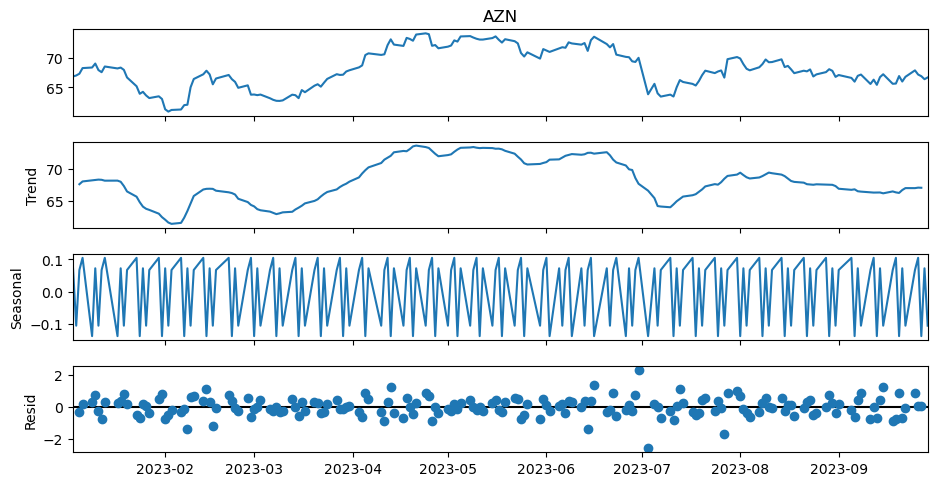

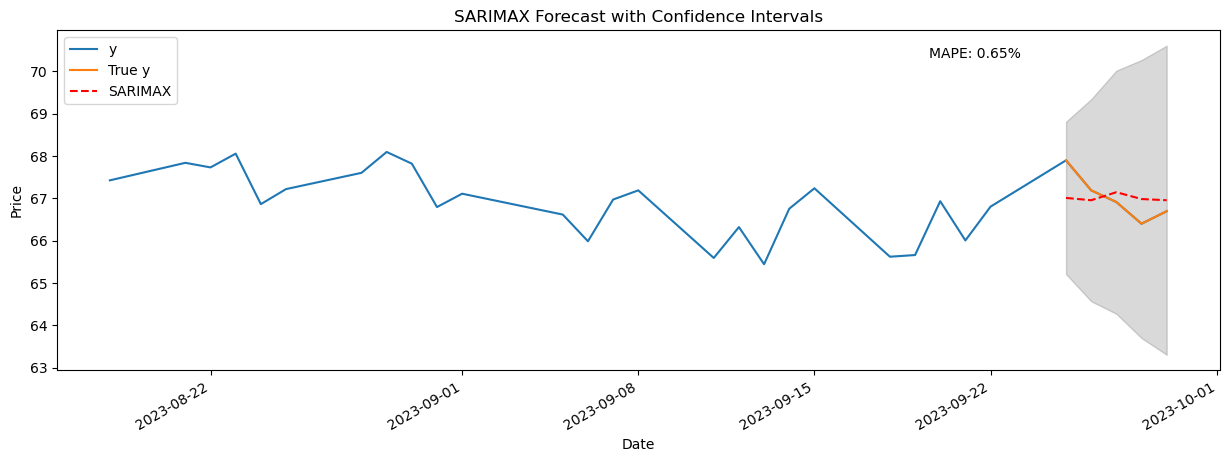

In [160]:
# Chapter 7 results
# The Real-World Example for AstraZeneca PLC Stock Price
# Auto-detect the parameters for SARIMAX model
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
# Seasonality decompose
data = nasdaq_assets_ac['AZN']['2023']
decomp = seasonal_decompose(data,
                            period = 5,
                            model = 'add')
fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(10, 5)
# SARIMAX model tuning
data = nasdaq_assets_ac['AZN']['2023']
dataframe = pd.DataFrame({
    'y': data,
    'day': data.index.day,
    'month': data.index.month,
    'day_year': data.index.dayofyear})
dataframe.dropna(inplace=True)
# Split into train and test sets
test_size = 5
train_set = dataframe.iloc[:-test_size]
test_set = dataframe.iloc[-test_size:]
#forecasting model
model = auto_arima(y = train_set['y'],
                   X = train_set[['month']],
                   d = 1,
                   m = 10,
                   n_jobs = -1,
                   seasonal = True,
                   stepwise = False)
print(model.summary())
# Generate predictions and confidence intervals
forecast, conf_int = model.predict(n_periods=test_size,
                                   X=test_set[['month']],
                                   return_conf_int=True)
# Convert forecast and confidence intervals to pandas Series for easier plotting
predictions = pd.Series(forecast).rename("SARIMAX")
predictions.index=test_set.index
m_mape = mean_absolute_percentage_error(test_set['y'], predictions) * 100
lower_conf = pd.Series(conf_int[:, 0],
                       index=test_set.index).rename("Lower CI")
upper_conf = pd.Series(conf_int[:, 1],
                       index=test_set.index).rename("Upper CI")
# Plotting the observed data, forecast, and confidence intervals
plt.figure(figsize=(15, 5))
dataframe[-30:]['y'].plot(legend=True,
                          title='SARIMAX Forecast with Confidence Intervals')
test_set['y'].rename('True y').plot(legend=True)
# Plotting the confidence intervals
predictions.plot(legend=True, color='red', linestyle='--')
# Plotting the confidence intervals
plt.fill_between(lower_conf.index, lower_conf, upper_conf, color='k', alpha=0.15)
# Displaying the MAPE value on the plot
plt.text(0.75, 0.95, f'MAPE: {m_mape:.2f}%',
         transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

In [161]:
# Machine Learning Predictions
# Define the function of lagged feature creation
def create_lagged_features(df, max_lag=5, 
                           prediction_window=1,
                           seasonal = True):
    '''
    Create a DataFrame with lagged features and datetime features.

    Parameters:
    df (pd.DataFrame): Input DataFrame with each column being a time series.
    max_lag (int): Maximum lag to create lagged features.
    prediction_window (int): The number of steps to predict into the future.
    seasonal(bool): If is True, the datetime features are applied

    Returns:
    pd.DataFrame: DataFrame with the first column as the target and others
                  as lagged features and datetime features.
    '''
    lagged_df = pd.DataFrame(index=df.index)
    for col in df.columns:

      # Create target column for prediction
      if prediction_window > 0:
          lagged_df[f'{col}_target_plus_{prediction_window}d'] = \
            df[col].shift(-prediction_window)


      # Create lagged features for each column
      for l in range(0, max_lag):
          lagged_df[f'{col}_lag_{l}'] = df[col].shift(l)

    # Adding datetime (seasonality) features
    if seasonal:
      lagged_df['day'] = lagged_df.index.day
      lagged_df['dayofweek'] = lagged_df.index.dayofweek
      lagged_df['month'] = lagged_df.index.month
      lagged_df['dayofyear'] = lagged_df.index.dayofyear
    return lagged_df

# AstraZeneca PLC Stock Price dataset
data = nasdaq_assets_ac['AZN']['2023']
# print the prepared data frame for AstraZeneca PLC Stock Price
print(create_lagged_features(pd.DataFrame(data)))

            AZN_target_plus_1d  AZN_lag_0  AZN_lag_1  AZN_lag_2  AZN_lag_3  \
Date                                                                         
2023-01-03           67.028870  66.864914        NaN        NaN        NaN   
2023-01-04           67.327850  67.028870  66.864914        NaN        NaN   
2023-01-05           68.282646  67.327850  67.028870  66.864914        NaN   
2023-01-06           68.379097  68.282646  67.327850  67.028870  66.864914   
2023-01-09           69.054199  68.379097  68.282646  67.327850  67.028870   
...                        ...        ...        ...        ...        ...   
2023-09-25           67.187637  67.896744  66.803535  66.005791  66.931564   
2023-09-26           66.911873  67.187637  67.896744  66.803535  66.005791   
2023-09-27           66.399734  66.911873  67.187637  67.896744  66.803535   
2023-09-28           66.695198  66.399734  66.911873  67.187637  67.896744   
2023-09-29                 NaN  66.695198  66.399734  66.911873 

In [162]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    '''
    Train a given model and evaluate it using Mean Absolute Percentage Error.

    Parameters:
    model: The machine learning model to train
    X_train, X_test, y_train, y_test: training and testing datasets

    Returns:
    tuple: containing MAPE, predictions array, and trained model
    '''
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, predictions) * 100
    return mape, predictions, model

def plot_predictions(y_train, y_test, predictions, 
                     mape=None, model_name=None, 
                     observe=30, figsize=(12, 5)):
    '''
    Plot the training data, test data, and predictions with an option to show MAPE and model name.

    Parameters:
    y_train (pd.Series): Training data.
    y_test (pd.Series): Test data.
    predictions (array): Predictions made by the model.
    observe (int): Number of days to observe from the training data.
    mape (float, optional): Mean Absolute Percentage Error. If provided, it's included in the title.
    model_name (str, optional): Name of the model used for prediction. If provided, it's included in the title.
    figsize (tuple): Dimensions of the figure (width, height).

    '''
    plt.figure(figsize=figsize)
    plt.plot(y_train[-observe:].index, 
             y_train[-observe:], 
             label='Training Data')
    plt.plot(y_test.index, y_test, 
             label='Test Data', alpha=0.7)
    plt.plot(y_test.index, predictions, 
             label='Predictions', alpha=0.7)
    title = 'Training Data and Test Predictions'
    if model_name:
        title = f'Training Data and Test Predictions, {model_name}'
    if mape is not None:
        title += f' (MAPE: {mape:.2f}%)'
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Prepare the data with lagged features
lagged_data = create_lagged_features(pd.DataFrame(data),
                                      prediction_window=1).dropna()
X = lagged_data.iloc[:, 1:-1]
y = lagged_data.iloc[:, 0]

# Split data into train and test subsets, 
# not shuffling for time series data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.05, 
                                                    shuffle=False)


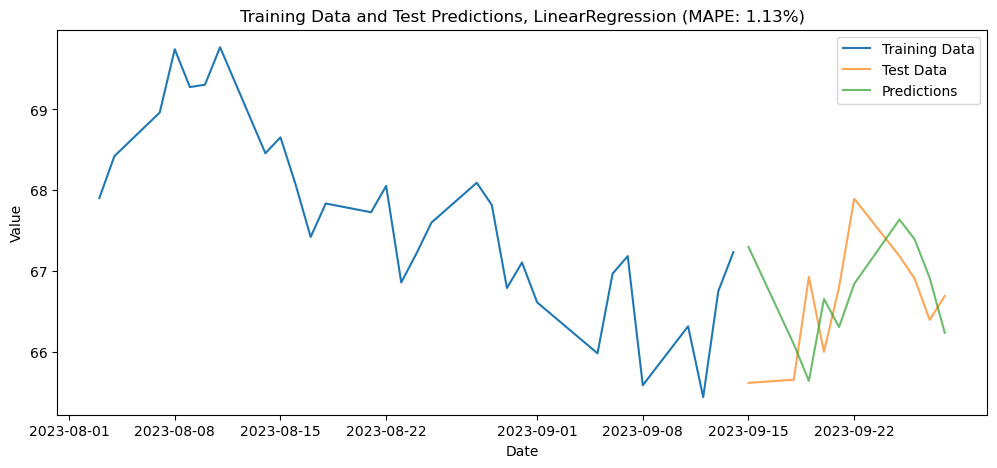

In [163]:
# Example model: Linear Regression
mape, predictions, trained_model = train_and_evaluate_model(LinearRegression(), 
                                                            X_train, X_test, y_train, y_test)
plot_predictions(y_train, y_test, predictions, mape, 'LinearRegression' )

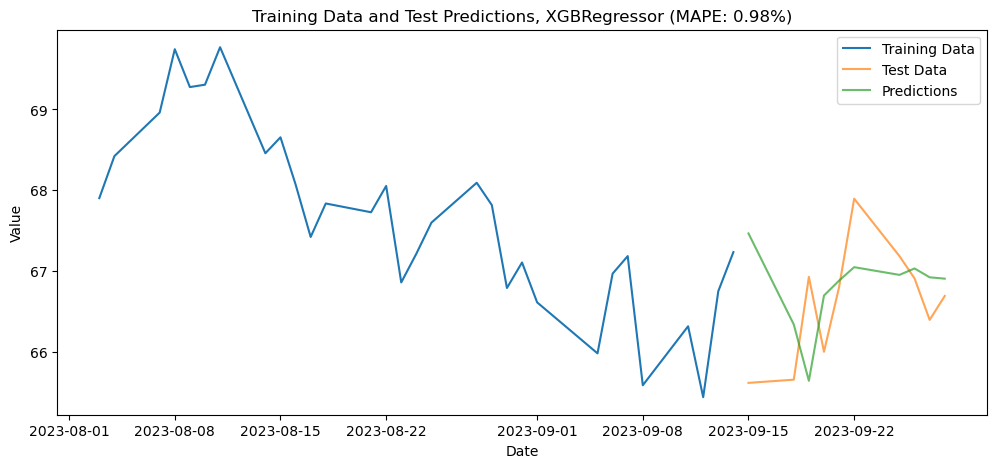

In [164]:
# Example model: XGBRegressor 
from xgboost import XGBRegressor
xgb_regressor = XGBRegressor(
    # Set maximum depth of each tree
    max_depth=3,           
    # Set number of trees in the ensemble
    n_estimators=100,      
    # Set learning rate for convergence
    learning_rate=0.1,     
    # Set subsampling rate of the training data
    subsample=0.8,         
    # Set subsampling rate of features for each tree
    colsample_bytree=0.8,  
    # Set min loss reduction needed to make further splits
    gamma=0,               
    # Set L1 regularization term on weights
    reg_alpha=0,           
    # Set L2 regularization term on weights
    reg_lambda=1           
)

mape, predictions, trained_model = train_and_evaluate_model(xgb_regressor, 
                                                            X_train, X_test, y_train, y_test)
plot_predictions(y_train, y_test, predictions, mape, 'XGBRegressor')

In [165]:
# Object for XGBClassifier model
from xgboost import XGBClassifier
xgb_classifier = XGBClassifier(
    # Set max depth for decision trees
    max_depth=3,           
    # Define number of trees to build
    n_estimators=100,      
    # Specify the learning rate for training
    learning_rate=0.1,     
    # Set fraction of samples to train each tree
    subsample=0.8,         
    # Set fraction of features for building trees
    colsample_bytree=0.8,  
    # Minimum loss reduction needed to further split
    gamma=0,               
    # L1 reg on weights, enhancing sparsity
    reg_alpha=0,           
    # L2 reg on weights, reducing overfitting
    reg_lambda=1,          
    # Objective function for binary classification
    objective='binary:logistic'
)

### 

/var/folders/02/hsxm96k91cl40xffg5xlqvhm0000gn/T/ipykernel_41371/3452845267.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  evaluation_metrics.loc[model_name, 'Actual'] = y_test[-1]
/var/folders/02/hsxm96k91cl40xffg5xlqvhm0000gn/T/ipykernel_41371/3452845267.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  evaluation_metrics.loc[model_name, 'Actual'] = y_test[-1]
/var/folders/02/hsxm96k91cl40xffg5xlqvhm0000gn/T/ipykernel_41371/3452845267.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

                      MAPE  Predictions     Actual  MAPE (5 days)
LinearRegression  1.128706    66.240835  66.695198       0.885358
XGBoost           0.983265    66.909019  66.695198       0.579479
SVR               1.427638    67.676138  66.695198       1.173993
ElasticNET        1.067756    66.409969  66.695198       0.807304


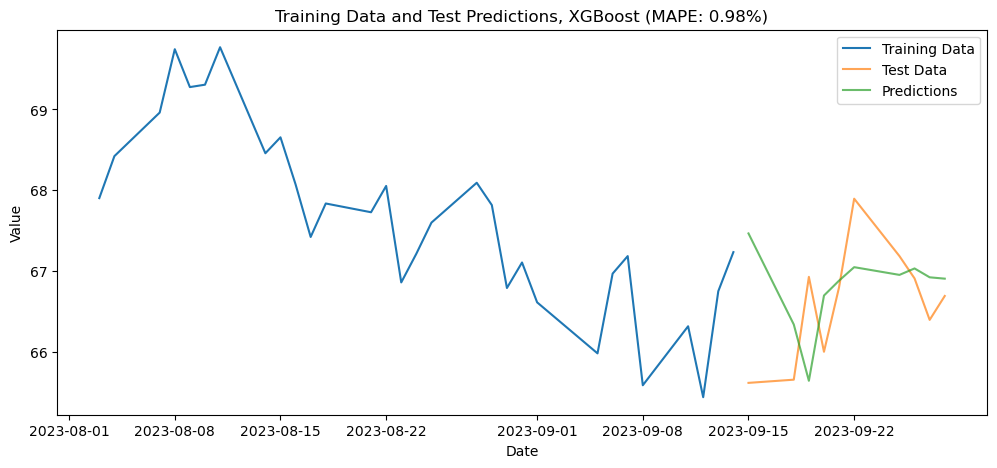

In [166]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNetCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
def train_and_evaluate_model(model, 
                             X_train, X_test, 
                             y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, predictions) * 100
    return mape, predictions, model
def plot_predictions(y_train, y_test, predictions, 
                     mape=None, model_name=None, 
                     observe=30, figsize=(12, 5)):
    plt.figure(figsize=figsize)
    plt.plot(y_train[-observe:].index, 
             y_train[-observe:], 
             label='Training Data')
    plt.plot(y_test.index, y_test, 
             label='Test Data', alpha=0.7)
    plt.plot(y_test.index, predictions, 
             label='Predictions', alpha=0.7)
    title = 'Training Data and Test Predictions'
    if model_name:
        title = f'Training Data and Test Predictions, {model_name}'
    if mape is not None:
        title += f' (MAPE: {mape:.2f}%)'
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
# Prepare the data
lagged_data = create_lagged_features(pd.DataFrame(data)).dropna()
X = lagged_data.iloc[:, 1:-1]
y = lagged_data.iloc[:, 0]
# split data to the train and the test subsets
# shuffle=False - for Time Series data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                   test_size=0.05,
                                   shuffle=False)
# Models set
models = {
    'LinearRegression': LinearRegression(),
    # xgb_regressor is the previously defined object
    'XGBoost': xgb_regressor,
    'SVR': SVR(),
    'ElasticNET': ElasticNetCV(cv=5, random_state=False)}
# DataFrame to store evaluation metrics for each ticker
evaluation_metrics = pd.DataFrame()
for model_name, model in models.items():
    mape, pred, _ = train_and_evaluate_model(model, 
                                             X_train, X_test, 
                                             y_train, y_test)
    evaluation_metrics.loc[model_name, 'MAPE'] = mape
    evaluation_metrics.loc[model_name, 'Predictions'] = pred[-1]
    evaluation_metrics.loc[model_name, 'Actual'] = y_test[-1]
    mape_5days = mean_absolute_percentage_error(pred[-5:], 
                                                y_test[-5:]) * 100
    evaluation_metrics.loc[model_name, 'MAPE (5 days)'] = mape_5days
# Display the evaluation metrics DataFrame
print(evaluation_metrics)
# Find the best model based on MAPE
best_model_name = evaluation_metrics['MAPE'].idxmin()
best_model = models[best_model_name]
best_mape, best_predictions, _ = \
    train_and_evaluate_model(best_model, 
                             X_train, X_test, y_train, y_test)
# Plot the results
plot_predictions(y_train, y_test, predictions, 
                 best_mape, best_model_name)

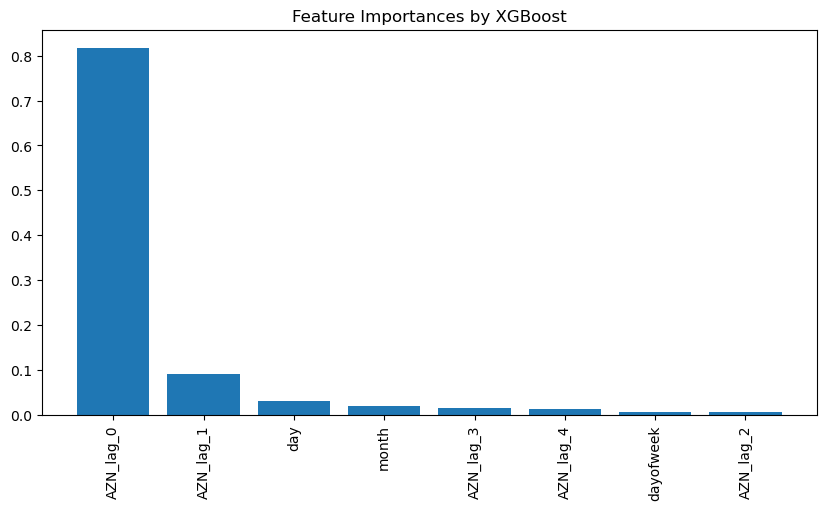

In [167]:
# Plot feature importances for XGBoost
mape, pred, xgboost_model = train_and_evaluate_model(xgb.XGBRegressor(objective='reg:squarederror'),
                                                     X_train, X_test, y_train, y_test)
importances = xgboost_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 5))
plt.title('Feature Importances by XGBoost')
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.show()

### ANN models and Hyperparameters Tuning

Best Parameters: {'hidden_layer_sizes': (100, 100)}
MAPE: 0.88%
MAPE (5 days): 0.51%
0.5107356324864953


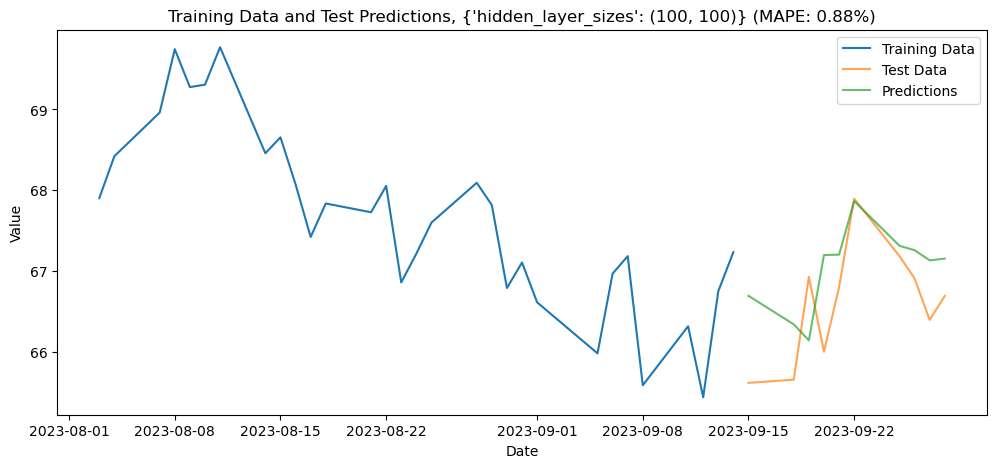

In [168]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import GridSearchCV
# Define Hyperparameters
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50),
                           (100, 50), (100, 100)]}
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
# Define the model and grid search
model = MLPRegressor(max_iter=5000, random_state=42)
grid_search = GridSearchCV(model,
                          param_grid,
                          scoring=make_scorer(mean_absolute_percentage_error))
grid_search.fit(X_train_scaled, y_train_scaled)
# Best model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
# Prediction using the best model
predictions_scaled = best_model.predict(X_test_scaled)
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
# Calculate metrics using only the test set portion
mape = mean_absolute_percentage_error(y_test, predictions) * 100
# print the results
print(f"Best Parameters: {best_params}")
print(f"MAPE: {mape:.2f}%")
mape_5days = mean_absolute_percentage_error(y_test[-5:], predictions[-5:]) * 100
print(f"MAPE (5 days): {mape_5days:.2f}%")
print(mean_absolute_percentage_error(y_test[-5:], predictions[-5:]) * 100)
# Plot the results
plot_predictions(y_train, y_test, predictions, mape, 
                 f"{best_params}")

Best Parameters: {'hidden_layer_sizes': (100,)}
MAPE: 1.03%
MAPE (5 days): 0.85%
0.8538789880261302


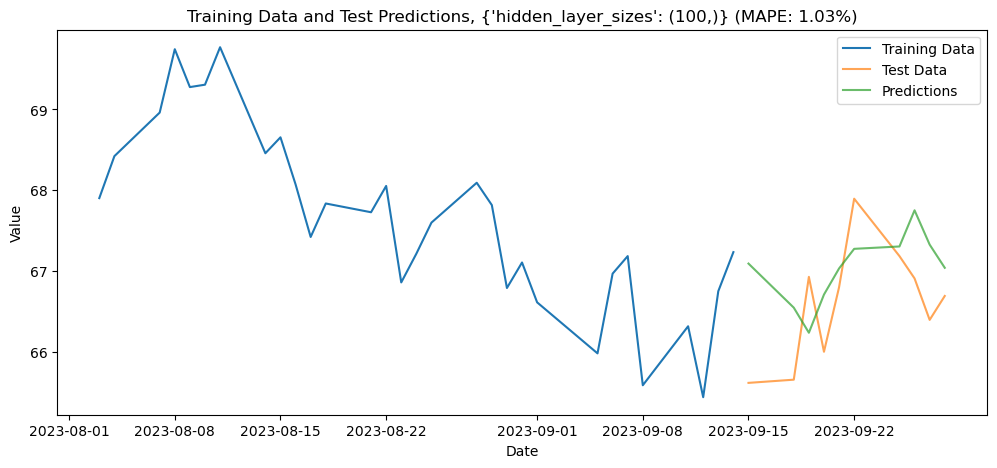

In [169]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Scaling data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50),
                           (100, 50), (100, 100)]
}

# Scale the features and target
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

# Define TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Define the model and grid search
model = MLPRegressor(max_iter=5000, random_state=42)
grid_search = GridSearchCV(model,
                           param_grid,
                           cv = tscv,
                           scoring=make_scorer(mean_squared_error))
grid_search.fit(X_train_scaled, y_train_scaled)

# Best model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Prediction using the best model
predictions_scaled = best_model.predict(X_test_scaled)
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()

# Calculate metrics using only the test set portion
mape = mean_absolute_percentage_error(y_test, predictions) * 100

# print the results
print(f"Best Parameters: {best_params}")
print(f"MAPE: {mape:.2f}%")
mape_5days = mean_absolute_percentage_error(y_test[-5:], predictions[-5:]) * 100
print(f"MAPE (5 days): {mape_5days:.2f}%")

print(mean_absolute_percentage_error(y_test[-5:], predictions[-5:]) * 100)

# Plot the results
plot_predictions(y_train, y_test, predictions, mape, 
                 f"{best_params}")

# Chapter 9
## &copy; Dr. Dmytro Zherlitsyn, 2024 <br>
## &copy; BPB Publications, 2024